# S4E4 - Abalone Ring Prediction EDA

Predict abalone rings given physical features

* Initial EDA and baseline linear regression model
* v5: add features: volume and shell density

# Installs

In [1]:
!pip install -q scienceplots

## Configuration

In [2]:
class Config():
    seed = 12
    folds = 5
    
config = Config()

## Imports

In [3]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

# optional if pip install scienceplots
import scienceplots
plt.style.use(['science','no-latex'])

## Read Data

In [4]:
root_dir = '/kaggle/input/playground-series-s4e4'
train = pd.read_csv(root_dir + '/train.csv') 
test = pd.read_csv(root_dir + '/test.csv') 
ss = pd.read_csv(root_dir + '/sample_submission.csv')

## Top Level EDA

In [5]:
# print all sets - assuming train,test, ss
print(f'Training Data Shape: {train.shape}') 
display(train.head()) 
print(f'Test Data Shape: {test.shape}') 
display(test.head()) 
print(f'Sample Submission Shape: {ss.shape}') 
display(ss.head())

Training Data Shape: (90615, 10)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


Test Data Shape: (60411, 9)


,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight
0,90615,M,0.645,0.475,0.155,1.2380,0.6185,0.3125,0.3005
1,90616,M,0.580,0.460,0.160,0.9830,0.4785,0.2195,0.2750
2,90617,M,0.560,0.420,0.140,0.8395,0.3525,0.1845,0.2405
3,90618,M,0.570,0.490,0.145,0.8740,0.3525,0.1865,0.2350
4,90619,I,0.415,0.325,0.110,0.3580,0.1575,0.0670,0.1050


Sample Submission Shape: (60411, 2)


,id,Rings
0,90615,10
1,90616,10
2,90617,10
3,90618,10
4,90619,10


In [6]:
def df_info(df): 
  summary = pd.DataFrame(df.dtypes, columns=['dtypes']) 
  summary['missing#'] = df.isna().sum() 
  summary['missing%'] = (df.isna().sum())/len(df) 
  summary['uniques'] = df.nunique().values 
  summary['count'] = df.count().values 
  return summary

df_info(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
id,int64,0,0.000000,90615,90615
Sex,object,0,0.000000,3,90615
Length,float64,0,0.000000,157,90615
Diameter,float64,0,0.000000,126,90615
Height,float64,0,0.000000,90,90615
Whole weight,float64,0,0.000000,3175,90615
Whole weight.1,float64,0,0.000000,1799,90615
Whole weight.2,float64,0,0.000000,979,90615
Shell weight,float64,0,0.000000,1129,90615
Rings,int64,0,0.000000,28,90615


### Takeaways
* Target = Rings
    * Datatype: int64 with cardinality of 28
* Decent size: train = 91K records, test = 60K records
* 8 Features + 'id'
* All features float except sex which is object (convert to categorial)
    * Some have low value counts (height has 90)
* No missing data to impute


## EDA - Univariate Distributions

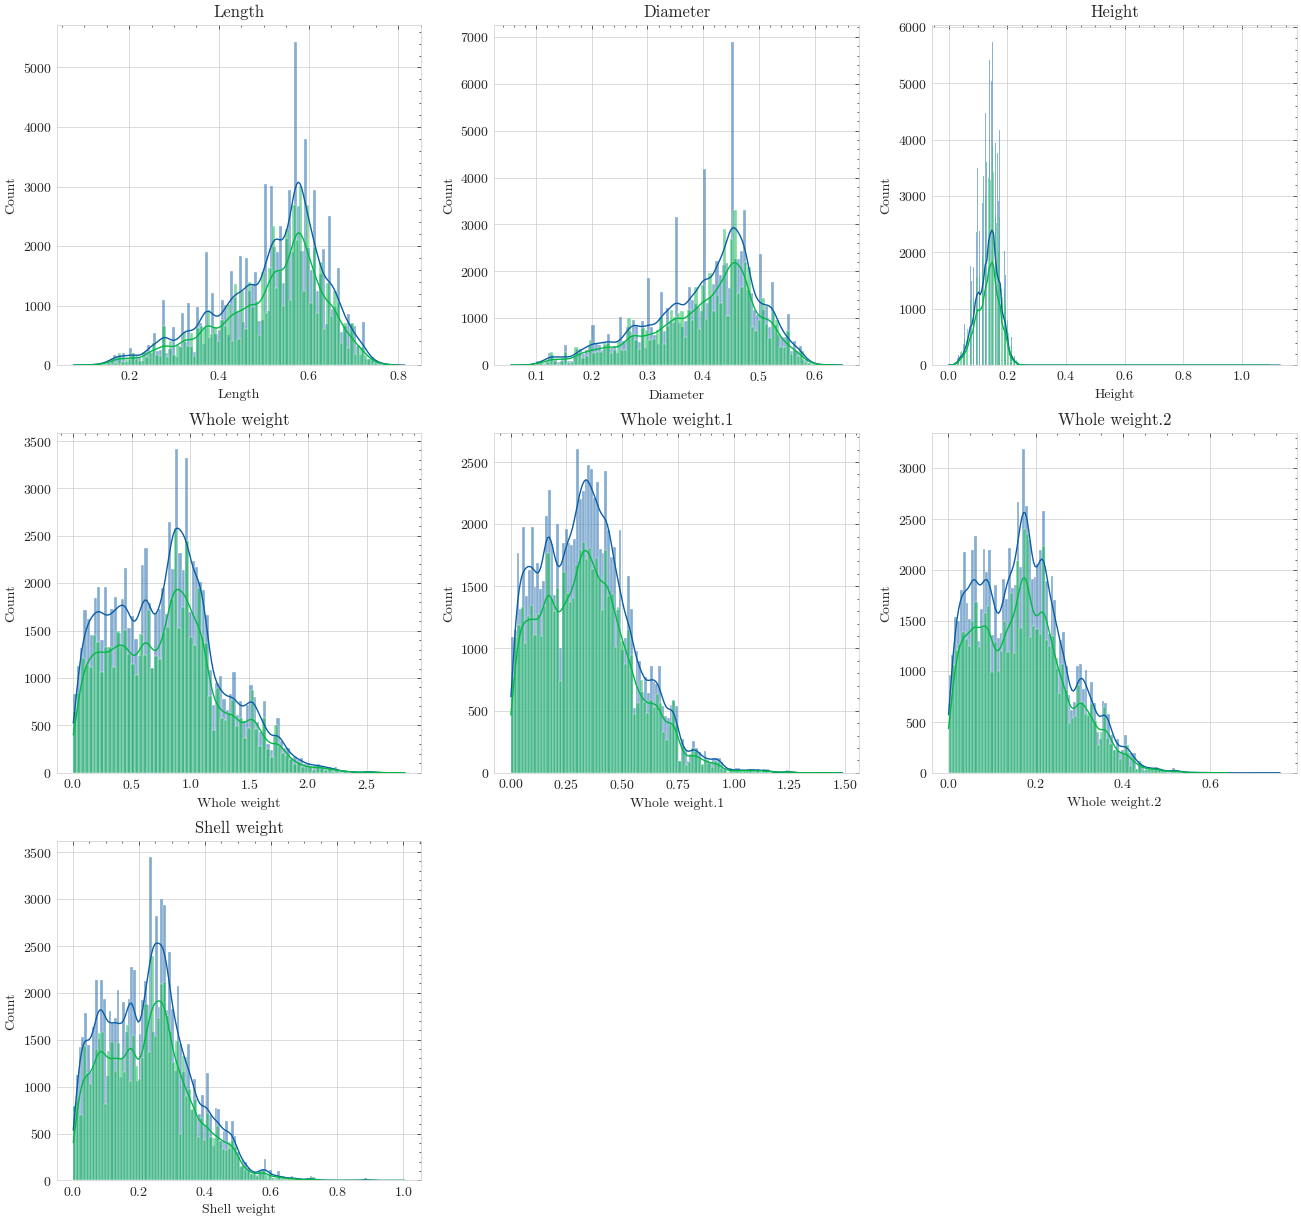

In [7]:
features = [col for col in train.columns if train[col].dtype=='float']
rows = int(np.ceil(len(features)/3)) 
plt.figure(figsize=(16,5*rows)) 
for i,col in enumerate(features): 
  plt.subplot(rows,3,i+1) 
  sns.histplot(train[col],kde=True) 
  sns.histplot(test[col], kde=True)
  plt.title(col)

### Takeaways
* Some skewed, try scaling/transforming

## Categorical Distributions
* The only categorical is sex
    * I = immature 

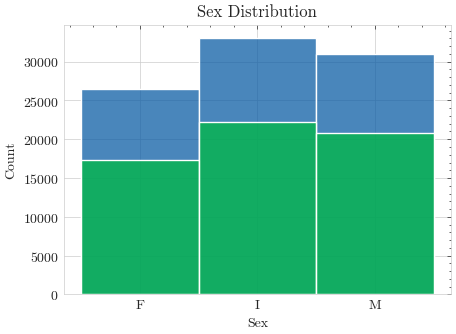

In [8]:
plt.figure(figsize=(5,3.5))
sns.histplot(train['Sex'])
sns.histplot(test['Sex'])
plt.title('Sex Distribution')
plt.show()

## Target Distribution

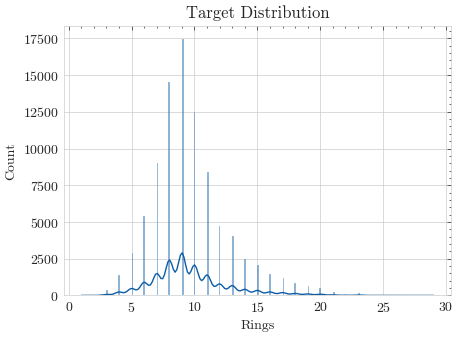

In [9]:
plt.figure(figsize=(5,3.5))
sns.histplot(train['Rings'],kde=True)
plt.title('Target Distribution')
plt.show()

In [10]:
# range is 1 to 29
np.min(train['Rings'])

1

## Correlations

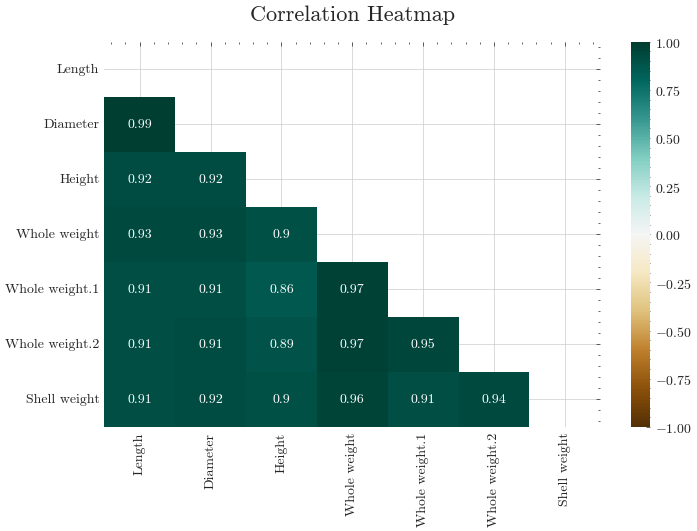

In [11]:
plt.figure(figsize=(8, 5)) 
mask = np.triu(np.ones_like(train[features].corr(),dtype=bool)) 
heatmap = sns.heatmap(train[features].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=16);

### Takeaways
* super high correlations in this data
* maybe PCA

## Correlation with Target

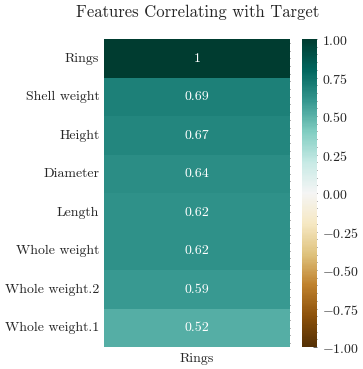

In [12]:
# add target to features
features = [col for col in train.columns if train[col].dtype=='float']
features_corr = features.copy()
features_corr.append('Rings')

plt.figure(figsize=(3, 4)) # set size by num of features 
heatmap = sns.heatmap(train[features_corr].corr()[['Rings']].sort_values(by='Rings', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':12}, pad=16);

## Preprocessing/Cleaning
* No imputation necessary
* convert sex to categorical


In [13]:
# drop id for both
train = train.drop('id',axis=1)
test = test.drop('id',axis=1)

# convert to categorical
train['Sex'] = train['Sex'].astype('category')
test['Sex'] = test['Sex'].astype('category')

# one hot encoding
train = pd.get_dummies(train, columns=['Sex'],drop_first=True)
test = pd.get_dummies(test, columns=['Sex'],drop_first=True)

train.head()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_I,Sex_M
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,False,False
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,False,False
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,True,False
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,False,True
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,True,False


## Feature Engineering
* None for first baseline
    * v5: add volume feature
* later look at:
    * adding features
    * scaling/transforming

In [14]:
def min_max_feat(df,feature):
    print(f'Min value: {np.min(df[feature])}, Max value: {np.max(df[feature])}')
    
min_max_feat(test,'Height')

Min value: 0.0, Max value: 1.095


In [15]:
# are there values of Height = 0?
h = train.Height
train[train.Height == 0.0]

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_I,Sex_M
7025,0.315,0.230,0.0,0.1340,0.0545,0.0245,0.3505,8,True,False
14208,0.430,0.340,0.0,0.3440,0.1880,0.0705,0.1050,8,True,False
32078,0.470,0.355,0.0,0.5785,0.2965,0.1550,0.1360,7,False,True
52324,0.315,0.230,0.0,0.1340,0.0530,0.0375,0.3505,7,True,False
70295,0.430,0.340,0.0,0.4060,0.2035,0.0960,0.1230,7,True,False
90295,0.430,0.325,0.0,0.3335,0.1350,0.0585,0.1050,10,False,True


### There are zero values in height
* Which is causing infinite values for volume
* for now impute with mode (most common value), which is .15
* Later maybe smart imputing

In [16]:
# any other values zero?
def find_zero_values(df):
    """
    Find the number of zero values in each column of a DataFrame.

    Args:
        df (pd.DataFrame): A pandas DataFrame.

    Returns:
        pd.Series: A pandas Series containing the number of zero values in each column.
    """
    return df.isin([0]).sum()

find_zero_values(test)

Length                0
Diameter              0
Height                2
Whole weight          0
Whole weight.1        0
Whole weight.2        0
Shell weight          0
Sex_I             38170
Sex_M             39628
dtype: int64

In [17]:
train = train.replace({'Height': {0:.15}})
test = test.replace({'Height': {0:.15}})
#find_zero_values(train)

## Add Features

In [18]:
# train['volume'] = (np.pi*(train.Diameter/2)**2)/train.Height  #cylindrical volume estimate
# test['volume'] = (np.pi*(test.Diameter/2)**2)/test.Height  #cylindrical volume estimate

train['volume'] = train.Diameter * train.Height * train.Length
test['volume'] = test.Diameter * test.Height * test.Length

# train['density_ww'] = train['Whole weight']/train.volume
# test['density_ww'] = test['Whole weight']/test.volume

# train['density_ww1'] = train['Whole weight.1']/train.volume
# test['density_ww1'] = test['Whole weight.1']/test.volume

# train['density_ww2'] = train['Whole weight.2']/train.volume
# test['density_ww2'] = test['Whole weight.2']/test.volume

train['density_sw'] = train['Shell weight']/train.volume
test['density_sw'] = test['Shell weight']/test.volume

train.head()

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings,Sex_I,Sex_M,volume,density_sw
0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11,False,False,0.035475,6.765328
1,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11,False,False,0.044761,7.149001
2,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6,True,False,0.000440,11.363636
3,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10,False,True,0.042394,5.897096
4,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9,True,False,0.030664,6.440830


In [19]:
float_feats = [col for col in test.columns if test[col].dtype=='float']
float_feats

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'volume',
 'density_sw']

## Scaling
* Doesn't help for linear regression, revisit later

In [20]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# std_scaler = StandardScaler()
# mm_scaler = MinMaxScaler()
# rob_scaler = RobustScaler()

# # swap out which scaler you want here (some people scale inside of CV)
# train[float_feats] = pd.DataFrame(rob_scaler.fit_transform(train[float_feats]))
# test[float_feats] = pd.DataFrame(rob_scaler.transform(test[float_feats]))



## Split Data
* Baseline is simple split with float features only
    * add sex feature v4
* Later n-fold cross validation

In [21]:
from sklearn.model_selection import train_test_split, KFold

# select final features
features = [col for col in test.columns]

target = train['Rings']
target_log = np.log1p(target)
y = target_log


## Test Train Split

In [22]:
# X_train, X_val, y_train, y_val = train_test_split(train[features], y, test_size=0.2, random_state=42)
# X_train.shape, X_val.shape, y_train.shape, y_val.shape

# X_test = test[features]

## CV Function

In [23]:

def run_cv_and_predict(train, test, features, model, seed, verbose=True):
    
    # initialize arrays 
    fold_scores = []
    oof = np.zeros(train.shape[0])
    preds = np.zeros((test.shape[0],folds))

    # Use KFold if target is continuous
    skf = KFold(n_splits=folds,random_state = seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict(x_valid)
        #fold_preds = fold_preds.reshape(len(fold_preds)) # sbabwtdt
        oof[val_idx] = fold_preds

        # Compute scores
        fold_score = mean_squared_error(y_valid,fold_preds,squared=False)  # CHOOSE METRIC HERE
        fold_scores.append(fold_score)
        if verbose:
          print(f'RMSLE Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        test_preds = model.predict(test[features])
        #test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
        preds[:,cur_fold-1] = test_preds  
        cur_fold +=1
    
    # Print mean fold and oof score 
    oof_score = mean_squared_error(y,oof,squared=False)
    # oof_score = np.sqrt(mean_squared_error(y,oof))
    print(f'RMSLE score: {np.mean(fold_scores):.5f}, Stdev: {np.std(fold_scores):.5f}, OOF score: {oof_score:.5f}')
    # print(f'RMSE score: {np.mean(scores):.5f}, Stdev: {np.std(scores):.5f}, OOF score: {oof_score:.5f}')

    return (preds,fold_scores,oof_score,oof)

## Models
* metric = root mean squared log error
* This is only in v1.4, kaggle uses 1.2,2,  so could install newer version or take log of RMSE manually instead...
* Going the manual route
    * make sure to take exponential before submission
   

In [24]:
# !pip uninstall -y sklearn
# !conda install -y scikit-learn=1.4.1.post1


In [53]:
# from sklearn.metrics import root_mean_squared_log_error  # only in v 1.4
from sklearn.metrics import mean_squared_error

model_results = []

seed = 12
folds = 5

## Baseline Model - Linear Regression
* Start with default linear regression on floats only

In [26]:
#from sklearn.linear_model import LinearRegression

# model_lr = LinearRegression()
# model_lr.fit(X_train, y_train) 

# pred_lr = model_lr.predict(X_val)
# pred_lr = np.clip(pred_lr, 1, 29)

# score_lr = mean_squared_error(y_val, pred_lr,squared=False)
# print(f'Linear Regression RMSLE: {score_lr:.5f}')

# first baseline: RMSLE: 0.16837, lb = .16628
# add sex feature, RMSLE: 0.16662, lb = .16438
# add std scaler, RMSLE: 0.16662: no change
# mm scaler, RMSLE: 0.16662: no change
# rob scaler, RMSLE: 0.16662: no change
# drop_first=False for OHE: RMSLE: 0.16662, no change
# add volume feature (cylindrical estimate): RMSLE: 0.16664, doesn't help
# add volume feature (l x w x h), RMSLE: 0.16166, helped
# add density_ww feature, RMSLE: 0.16154, helped a little
# density ww.1: RMSLE: 0.16160
# density ww.2: RMSLE: 0.16156
# density shell weight: RMSLE: 0.16130
# try just ww and sw: RMSLE: 0.16130
# ww,ww1,ww2, and sw: RMSLE: 0.16130
# so, just keep vol and sw, also clamped 1 to 29, RMSLE: 0.16130, lb = .15828
# remove clamp: .15967 (worse)


## Linear Regression with CV

In [27]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
preds_lr,scores_lr,oof_score_lr,oof_lr = run_cv_and_predict(train,test,features,model,seed)

# 5 fold cv, vol + shell density: RMSLE score: 0.15917, Stdev: 0.00104, OOF score: 0.15918, lb = .15825

RMSLE Score, fold 1: 0.1601584922145212
RMSLE Score, fold 2: 0.15848563931041154
RMSLE Score, fold 3: 0.15746070193266837
RMSLE Score, fold 4: 0.1596682161072246
RMSLE Score, fold 5: 0.16008826087643033
RMSLE score: 0.15917, Stdev: 0.00104, OOF score: 0.15918


## Random Forest

In [29]:
%%time
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()
preds_rf,scores_rf,oof_score_rf,oof_rf = run_cv_and_predict(train,test,features,model_rf,config.seed,verbose=True)


RMSLE Score, fold 1: 0.15377170191755274
RMSLE Score, fold 2: 0.15283458730211988
RMSLE Score, fold 3: 0.15087707880368423
RMSLE Score, fold 4: 0.1536743130396224
RMSLE Score, fold 5: 0.15468104435683286
RMSLE score: 0.15317, Stdev: 0.00129, OOF score: 0.15317


## Extra Trees

In [30]:
from sklearn.ensemble import ExtraTreesRegressor

model_etc = ExtraTreesRegressor()
preds_etc,scores_etc,oof_score_etc,oof_etc = run_cv_and_predict(train,test,features,model_etc,config.seed,verbose=True)

RMSLE Score, fold 1: 0.15507563860293727
RMSLE Score, fold 2: 0.15363423987440625
RMSLE Score, fold 3: 0.15249034066586142
RMSLE Score, fold 4: 0.15422167984346583
RMSLE Score, fold 5: 0.1556388509509807
RMSLE score: 0.15421, Stdev: 0.00110, OOF score: 0.15422


## XGBoost

In [31]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor() #max_depth= 8, 
#                           n_estimators= 125, 
#                           random_state= 0,  
#                           learning_rate= 0.03)

preds_xgb,scores_xgb,oof_score_xgb,oof_xgb = run_cv_and_predict(train,test,features,model_xgb,config.seed,verbose=True)

# so fast...
# default with vol+sh_den: RMSLE score: 0.15103, Stdev: 0.00141, OOF score: 0.15103

RMSLE Score, fold 1: 0.1527537043458887
RMSLE Score, fold 2: 0.1503216069273085
RMSLE Score, fold 3: 0.148839624328889
RMSLE Score, fold 4: 0.1508871384552087
RMSLE Score, fold 5: 0.15232844163953788
RMSLE score: 0.15103, Stdev: 0.00141, OOF score: 0.15103


## Catboost

In [33]:
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(verbose=False) # ,cat_features=obj_cols,task_type='GPU')
# model_cat.fit(X_train,y_train)
# preds_cat = model_cat.predict_proba(X_valid)[:,1]
# score_cat = roc_auc_score(y_valid,preds_cat)
# print(f'Catboost score: {score_cat}')

preds_cat,scores_cat,oof_score_cat,oof_cat = run_cv_and_predict(train,test,features,model_cat,config.seed,verbose=True)

# default vol+sh_density: RMSLE score: 0.14906, Stdev: 0.00137, OOF score: 0.14907

RMSLE Score, fold 1: 0.15068053358764302
RMSLE Score, fold 2: 0.1481559302142825
RMSLE Score, fold 3: 0.14697536798439323
RMSLE Score, fold 4: 0.14920663108305818
RMSLE Score, fold 5: 0.15030339855154717
RMSLE score: 0.14906, Stdev: 0.00137, OOF score: 0.14907


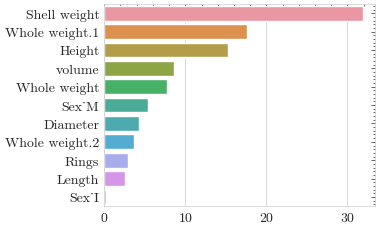

In [35]:
model_cat.feature_importances_
indices = np.argsort(model_cat.feature_importances_)[::-1]
g = sns.barplot(y=train.columns[indices[0:16]],x = model_cat.feature_importances_[indices[0:16]] , orient='h')

## LightGBM

In [37]:
from lightgbm import LGBMRegressor

model_lgbm = LGBMRegressor()
# model_lgbm.fit(X_train,y_train)
# pred_lgbm = model_lgbm.predict_proba(X_valid)[:,1]
# score_lgbm = accuracy_score(y_valid,pred_lgbm)
# print(f'LGBM Accuracy: {score_lgbm}')

preds_lgbm,scores_lgbm,oof_score_lgbm,oof_lgbm = run_cv_and_predict(train,test,features,model_lgbm,config.seed,verbose=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1839
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 11
[LightGBM] [Info] Start training from score 2.328627
RMSLE Score, fold 1: 0.1513613226843005
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1842
[LightGBM] [Info] Number of data points in the train set: 72492, number of used features: 11
[LightGBM] [Info] Start training from score 2.329687
RMSLE Score, fold 2: 0.14889110126947824
[LightGBM] [Warning] Found whitespace in feature_names, replace with underl

## Model Comparison

In [54]:
model_results.append(['Linear Regression',np.mean(scores_lr)])
model_results.append(['Random Forest',np.mean(scores_rf)])
model_results.append(['Extra Trees', np.mean(scores_etc)])
model_results.append(['XGBoost', np.mean(scores_xgb)])
model_results.append(['Catboost',np.mean(scores_cat)])
model_results.append(['LightGBM', np.mean(scores_lgbm)])

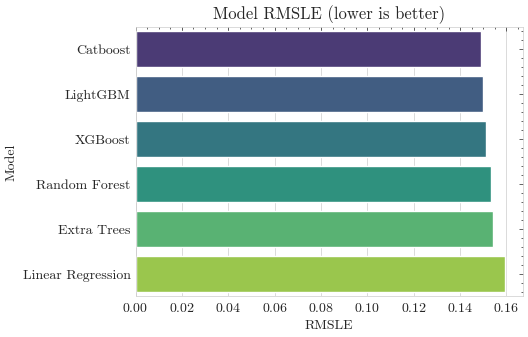

In [55]:
def plot_model_accuracies(model_results):
    """
    Make a horizontal bar plot of a 2D list with model names in column1 and root mean squared log error in the column2.
    """

    plt.figure(figsize=(5,3.5))
    # Create a DataFrame from the 2D list
    df = pd.DataFrame(model_results, columns=['Model', 'RMSLE'])

    # Create a horizontal bar plot using Seaborn
    sns.barplot(x='RMSLE', y='Model', data=df, palette='viridis',order=df.sort_values('RMSLE')['Model'])
    plt.xlabel('RMSLE')
    plt.ylabel('Model')
    plt.title('Model RMSLE (lower is better)')
    plt.show()
    
    
plot_model_accuracies(model_results)


## Select Test Predictions

In [56]:
#preds = model_lr.predict(X_test)
#preds = np.expm1(preds)

preds = np.mean(preds_xgb,axis=1)

# exponentiate minus one (inverse of log1p)
preds = np.expm1(preds)

# clamp preds to (1,29)
preds = np.clip(preds, 1, 29)

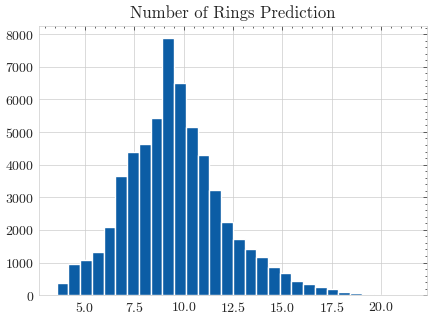

In [57]:
plt.figure(figsize=(5,3.5))
plt.hist(preds, bins=30)
plt.title('Number of Rings Prediction')
plt.show()

## Submission

In [58]:
ss.Rings = preds
ss.to_csv('submission.csv',index=False)
ss.head()

,id,Rings
0,90615,9.787657
1,90616,9.605183
2,90617,10.024240
3,90618,10.111597
4,90619,7.550039
